# Sentiment Analysis with BERT

> TL;DR In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

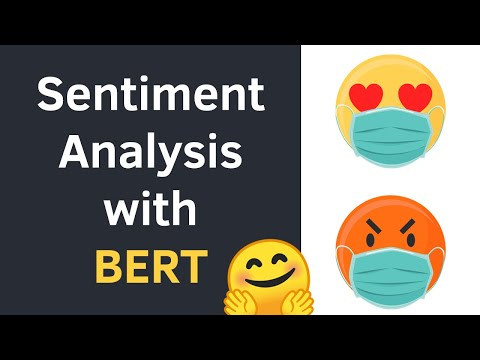

In [ ]:
#@title Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('8N-nM3QW7O0', width=720, height=420)

In [ ]:
!nvidia-smi

Tue Sep 22 07:29:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 890kB 2.9MB/s 
     |████████████████████████████████| 1.1MB 10.0MB/s 
     |████████████████████████████████| 3.0MB 18.8MB/s 
     |████████████████████████████████| 890kB 17.6MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.6.0+cu101
transformers 3.1.0


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 39.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [ ]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df['content']

0        Update: After getting a response from the deve...
1        Used it for a fair amount of time without any ...
2        Your app sucks now!!!!! Used to be good but no...
3        It seems OK, but very basic. Recurring tasks n...
4        Absolutely worthless. This app runs a prohibit...
                               ...                        
15741    I believe that this is by far the best app wit...
15742                         It sometimes crashes a lot!!
15743                           Works well for what I need
15744                                             Love it.
15745    Really amazing and helped me sooo much just i ...
Name: content, Length: 15746, dtype: object

In [ ]:
df.shape

(15746, 11)

We have about 16k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Great, no missing values in the score and review texts! Do we have class imbalance?

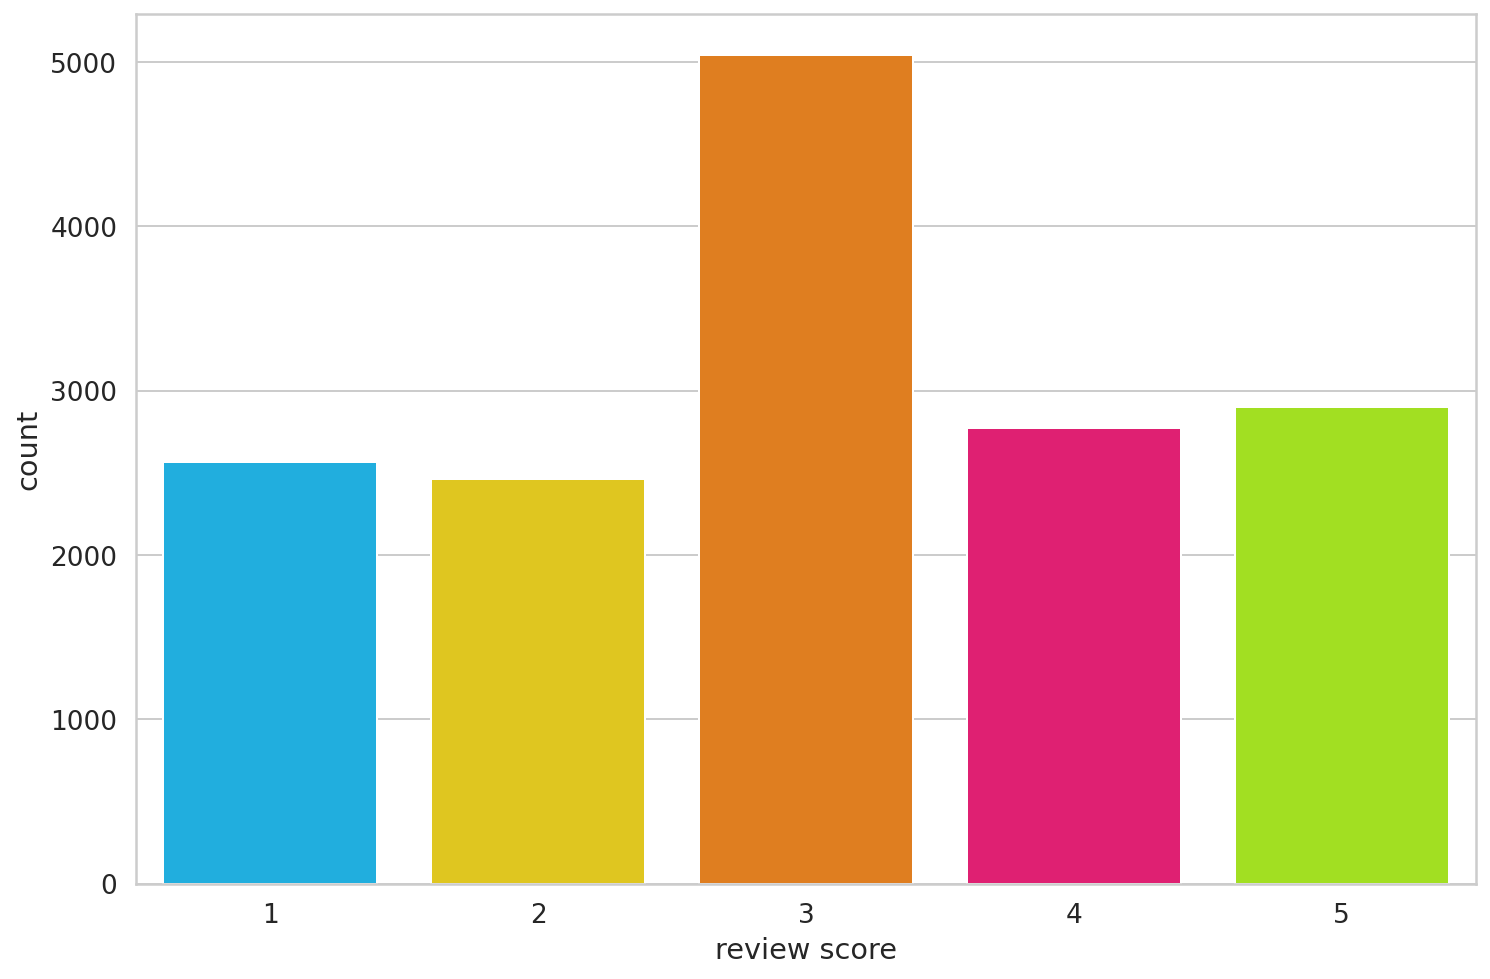

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [ ]:
import re 
import string   
for i,j in df.iterrows(): 
  df['content'][i] = str(' '.join(re.sub('['+string.punctuation+']', '', df['content'][i]).lower().split()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,update after getting a response from the devel...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,your app sucks now used to be good but now doe...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,it seems ok but very basic recurring tasks nee...,1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,absolutely worthless this app runs a prohibiti...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,i believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,it sometimes crashes a lot,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,works well for what i need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,love it,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

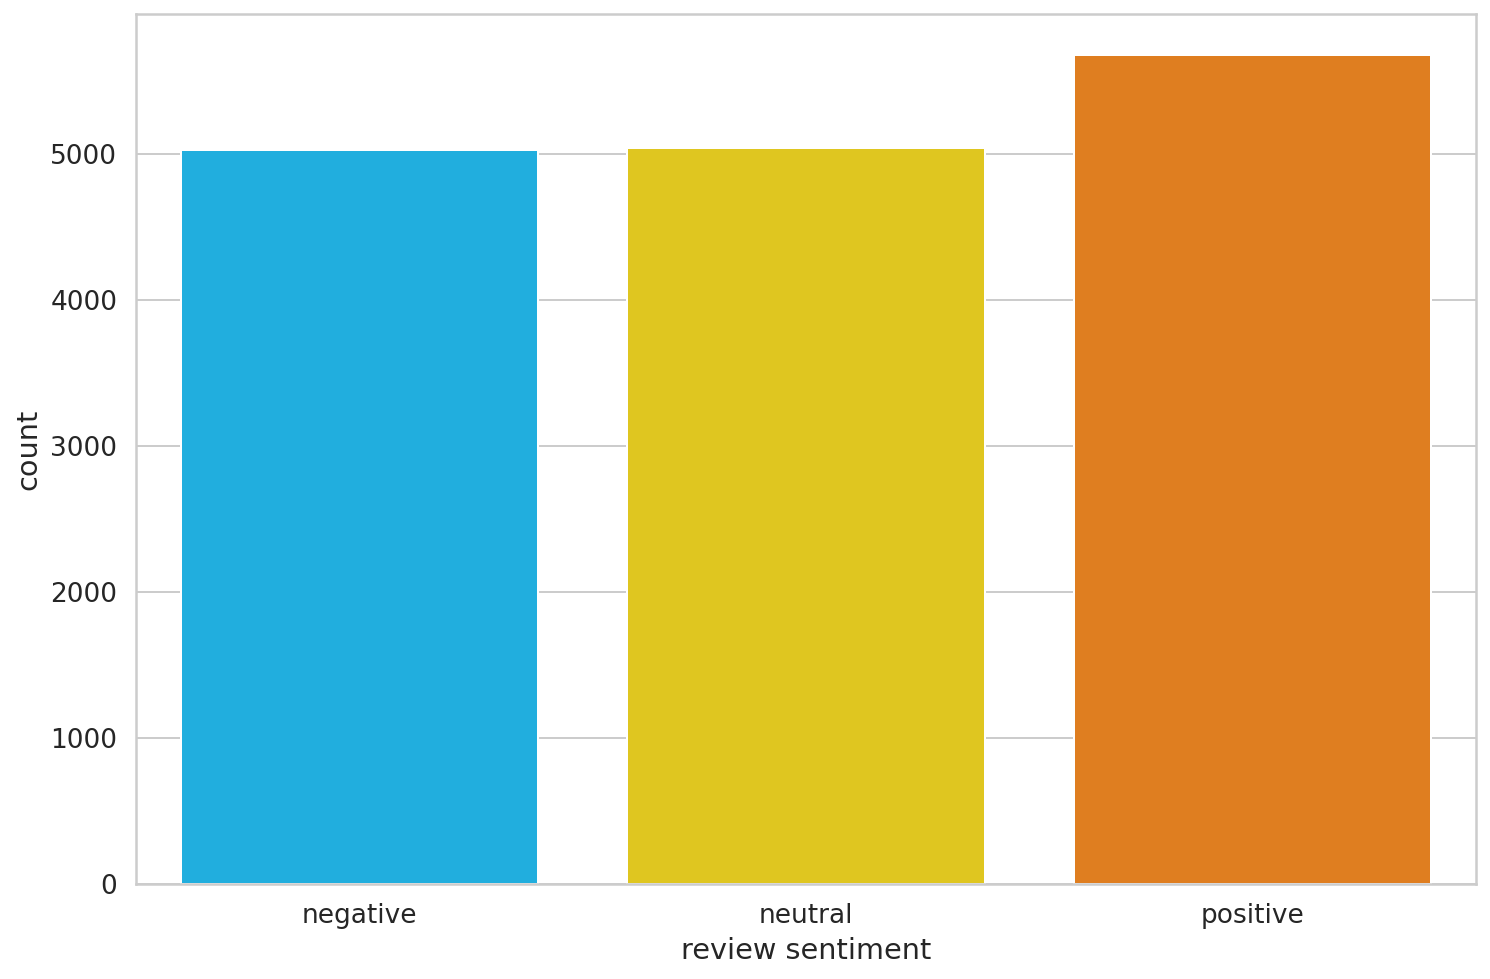

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks!!'

In [ ]:
!pip install clean-text[gpl]

In [ ]:
from cleantext import clean

In [ ]:
'''
clean(sample_txt,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct = True,                 # fully remove punctuation
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"  
)


df['content'] = df.content.apply(clean)
'''

'\nclean(sample_txt,\n    fix_unicode=True,               # fix various unicode errors\n    to_ascii=True,                  # transliterate to closest ASCII representation\n    lower=True,                     # lowercase text\n    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them\n    no_urls=False,                  # replace all URLs with a special token\n    no_emails=False,                # replace all email addresses with a special token\n    no_phone_numbers=False,         # replace all phone numbers with a special token\n    no_numbers=False,               # replace all numbers with a special token\n    no_digits=False,                # replace all digits with a special token\n    no_currency_symbols=False,      # replace all currency symbols with a special token\n    no_punct = True,                 # fully remove punctuation\n    replace_with_url="<URL>",\n    replace_with_email="<EMAIL>",\n    replace_with_phone_number="<PHONE>",\n  

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks!!
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '!', '!']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 999, 999]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
df['content']

0        update after getting a response from the devel...
1        used it for a fair amount of time without any ...
2        your app sucks now used to be good but now doe...
3        it seems ok but very basic recurring tasks nee...
4        absolutely worthless this app runs a prohibiti...
                               ...                        
15741    i believe that this is by far the best app wit...
15742                           it sometimes crashes a lot
15743                           works well for what i need
15744                                              love it
15745    really amazing and helped me sooo much just i ...
Name: content, Length: 15746, dtype: object

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134,  999,  999,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.content[1000]:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

and plot the distribution:

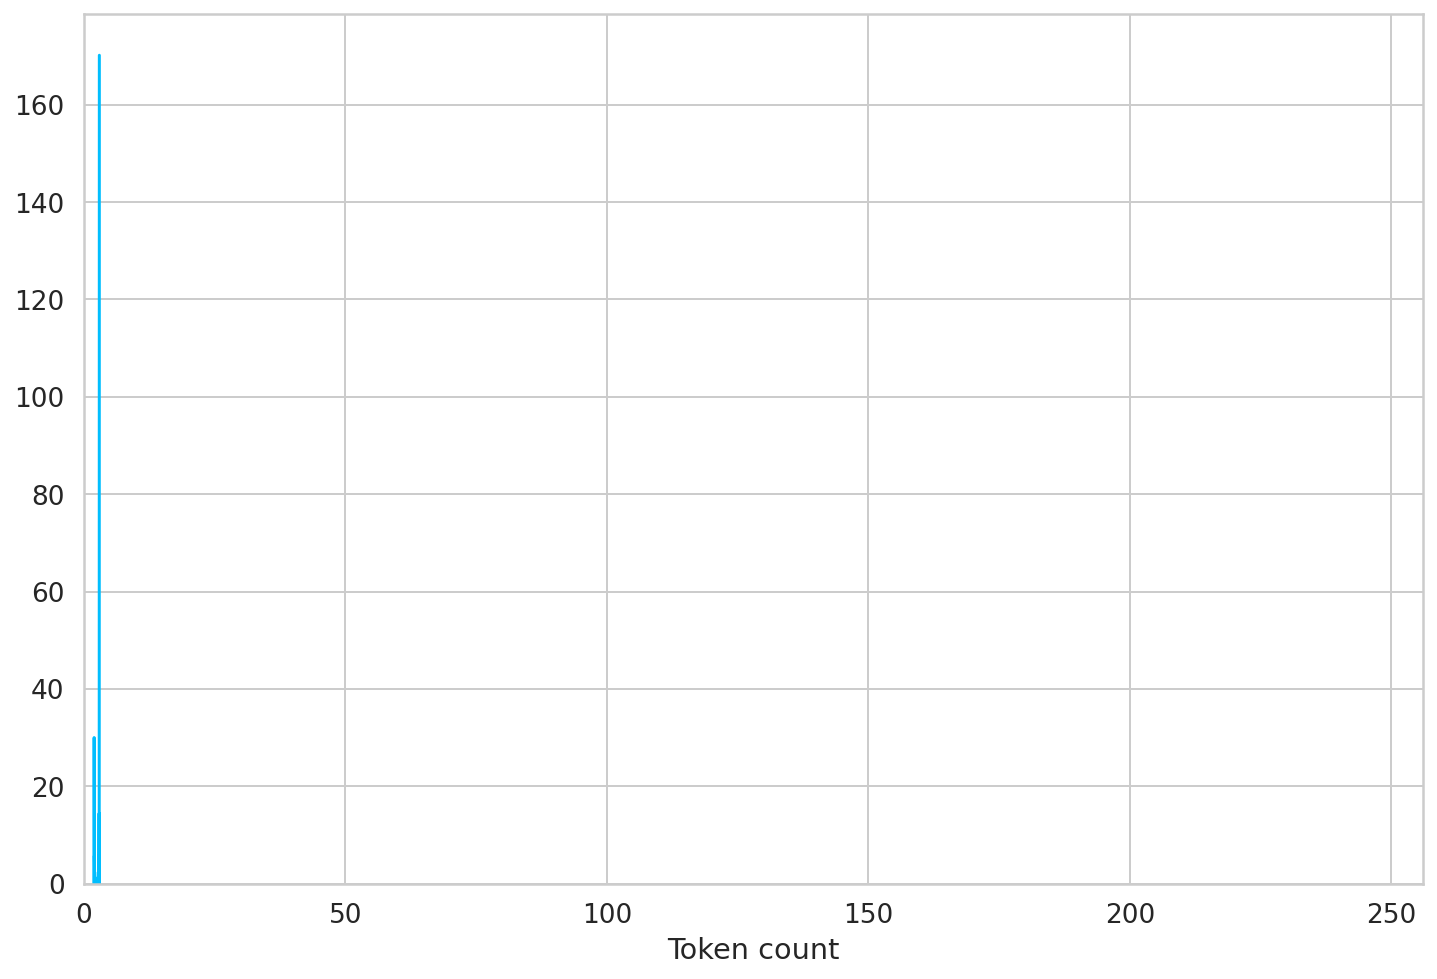

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
df_train['content']

1562        You cant have your to do list as notifications
15084    I havent been using this very long and its not...
7417     1 Кривой и неработающий экспорт и импорт 2 Нел...
12044    Love it so far Wish it had a widget for Androi...
12410    Liked the prioritization by dragging and the h...
                               ...                        
5191     This app is not getting opened pls look after ...
13418    Do not download this app There are Ads everyth...
5390     The app keeps stopping repeatedly It would be ...
860                   Very helpful and detailed applove it
7270     Decent app but repeatedly asking me to pay a m...
Name: content, Length: 14171, dtype: object

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 160])
torch.Size([32, 160])
torch.Size([32])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 160])
torch.Size([32, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2314, 0.2559, 0.5127],
        [0.3591, 0.2872, 0.3537],
        [0.2205, 0.3595, 0.4200],
        [0.2398, 0.3220, 0.4381],
        [0.2410, 0.2857, 0.4733],
        [0.2081, 0.2331, 0.5588],
        [0.2830, 0.2203, 0.4967],
        [0.3955, 0.2422, 0.3623],
        [0.2440, 0.2820, 0.4740],
        [0.2334, 0.3704, 0.3962],
        [0.3897, 0.3196, 0.2908],
        [0.2356, 0.3820, 0.3825],
        [0.3760, 0.2628, 0.3613],
        [0.1504, 0.3199, 0.5297],
        [0.2596, 0.3243, 0.4161],
        [0.2112, 0.3309, 0.4580],
        [0.2482, 0.2187, 0.5332],
        [0.1916, 0.3475, 0.4608],
        [0.1891, 0.2957, 0.5152],
        [0.2053, 0.3719, 0.4228],
        [0.2781, 0.2546, 0.4674],
        [0.4047, 0.3298, 0.2655],
        [0.2250, 0.2730, 0.5020],
        [0.1960, 0.3103, 0.4937],
        [0.3414, 0.1952, 0.4634],
        [0.1617, 0.2918, 0.5465],
        [0.1813, 0.1752, 0.6434],
        [0.2192, 0.2956, 0.4852],
        [0.1681, 0.2278, 0.6042],
        [0.209

In [ ]:
type(input)

method

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
'''
import numpy as np
import torch  
import math
import torch
from torch.optim import Optimizer
import operator
import functools
from copy import copy
from math import sqrt
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


class AdaBound(Optimizer):
    """  AdaBound code from https://github.com/Luolc/AdaBound/blob/master/adabound/adabound.py
    Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss
'''

'\nimport numpy as np\nimport torch  \nimport math\nimport torch\nfrom torch.optim import Optimizer\nimport operator\nimport functools\nfrom copy import copy\nfrom math import sqrt\nimport matplotlib.pyplot as plt\n\nif torch.cuda.is_available():\n    device = torch.device("cuda:0")\nelse:\n    device = torch.device("cpu")\n\n\nclass AdaBound(Optimizer):\n    """  AdaBound code from https://github.com/Luolc/AdaBound/blob/master/adabound/adabound.py\n    Implements AdaBound algorithm.\n    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.\n    Arguments:\n        params (iterable): iterable of parameters to optimize or dicts defining\n            parameter groups\n        lr (float, optional): Adam learning rate (default: 1e-3)\n        betas (Tuple[float, float], optional): coefficients used for computing\n            running averages of gradient and its square (default: (0.9, 0.999))\n        final_lr (float, optional): final (SGD) learning rate

In [ ]:
EPOCHS = 15

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias = False)
#relative_step=False,scale_parameter=False
#correct_bias = False
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.7344703506804481 accuracy 0.6636087784912851


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5743128108978272 accuracy 0.7496823379923762

Epoch 2/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.49020278766650377 accuracy 0.8007197798320514


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4962405127286911 accuracy 0.8170266836086404

Epoch 3/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3223878263703991 accuracy 0.8827887940159481


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.47765381455421446 accuracy 0.843710292249047

Epoch 4/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.23226014291342037 accuracy 0.9190600522193212


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4770951622724533 accuracy 0.8576874205844981

Epoch 5/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.17582792834153832 accuracy 0.9405828805306612


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4942741557955742 accuracy 0.8716645489199493

Epoch 6/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.14088557440573118 accuracy 0.9538494107684709


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5400534794479609 accuracy 0.8703939008894537

Epoch 7/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.12079983170125339 accuracy 0.9587185096323478


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5701604291796685 accuracy 0.8754764930114358

Epoch 8/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.10015600891920484 accuracy 0.9665514078046715


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6010815690457821 accuracy 0.878017789072427

Epoch 9/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.08497868696911971 accuracy 0.9722673064709618


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6091560611128807 accuracy 0.8729351969504447

Epoch 10/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.07520936122826358 accuracy 0.9740314727259898


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6458629801869392 accuracy 0.8742058449809403

Epoch 11/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.06729367773629868 accuracy 0.9776303718862466


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6663208569586277 accuracy 0.8792884371029225

Epoch 12/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.06018138769619865 accuracy 0.9792534048408722


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6808386261761189 accuracy 0.8729351969504447

Epoch 13/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.054592517905439716 accuracy 0.9803824712440901


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7018765470385552 accuracy 0.8716645489199493

Epoch 14/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.04936169344053076 accuracy 0.9821466374991179


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6954484471678734 accuracy 0.8754764930114358

Epoch 15/15
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.05126879824710165 accuracy 0.9817232375979112


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6978419274091721 accuracy 0.8742058449809403

CPU times: user 38min 13s, sys: 19min 37s, total: 57min 51s
Wall time: 57min 59s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

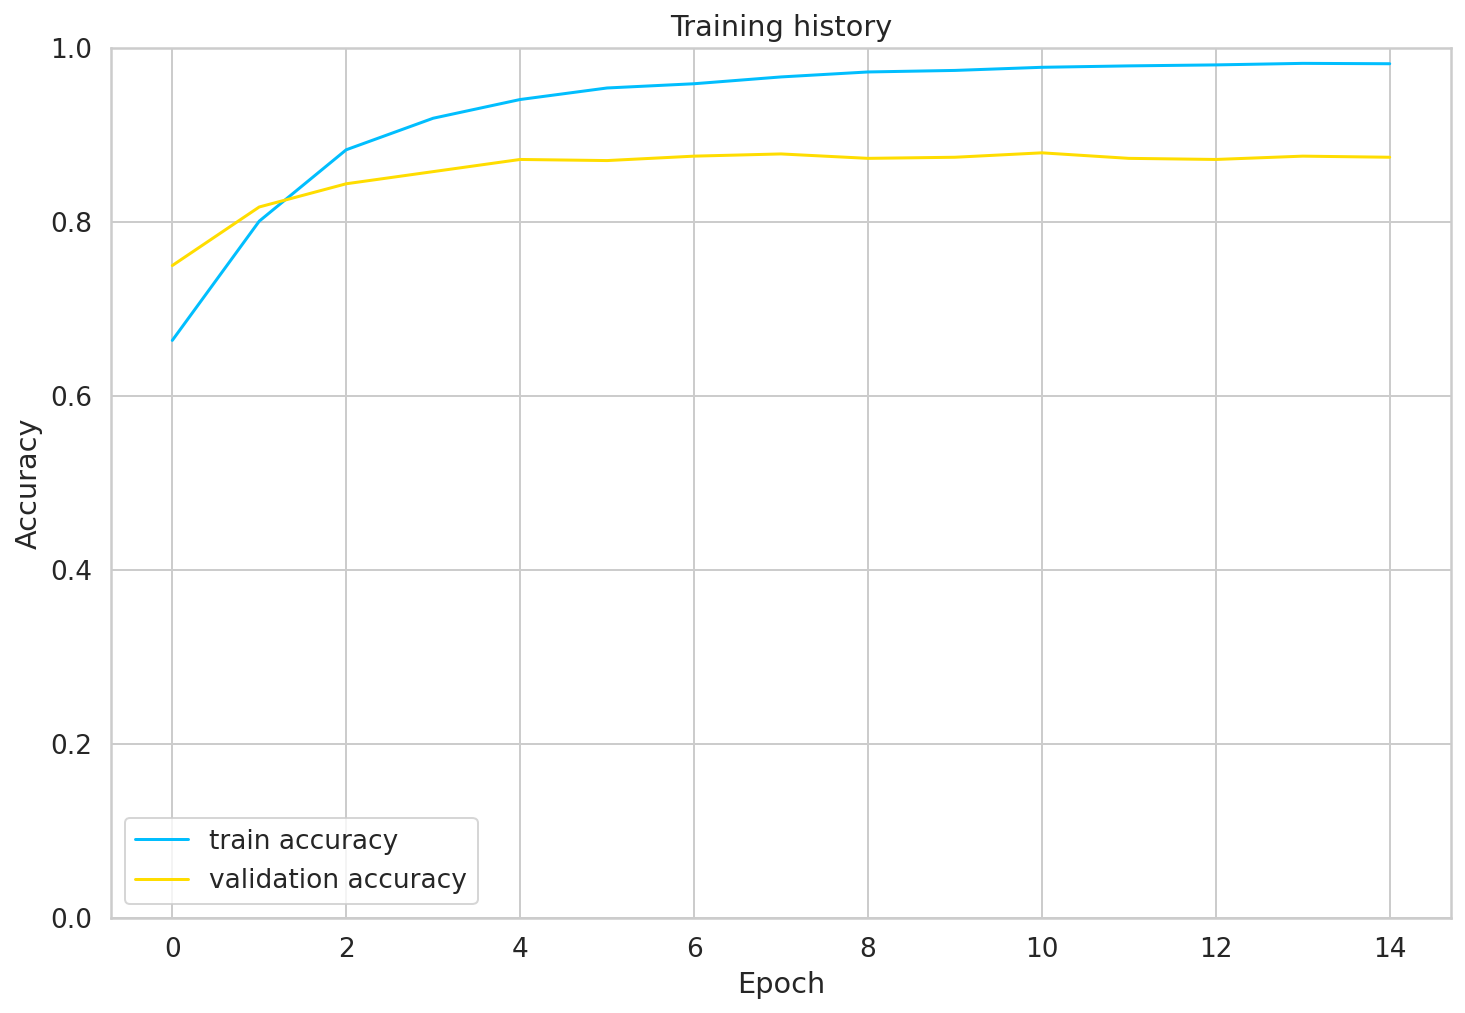

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8934010152284263

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.94      0.87      0.90       245
     neutral       0.82      0.89      0.85       254
    positive       0.92      0.92      0.92       289

    accuracy                           0.89       788
   macro avg       0.90      0.89      0.89       788
weighted avg       0.90      0.89      0.89       788



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

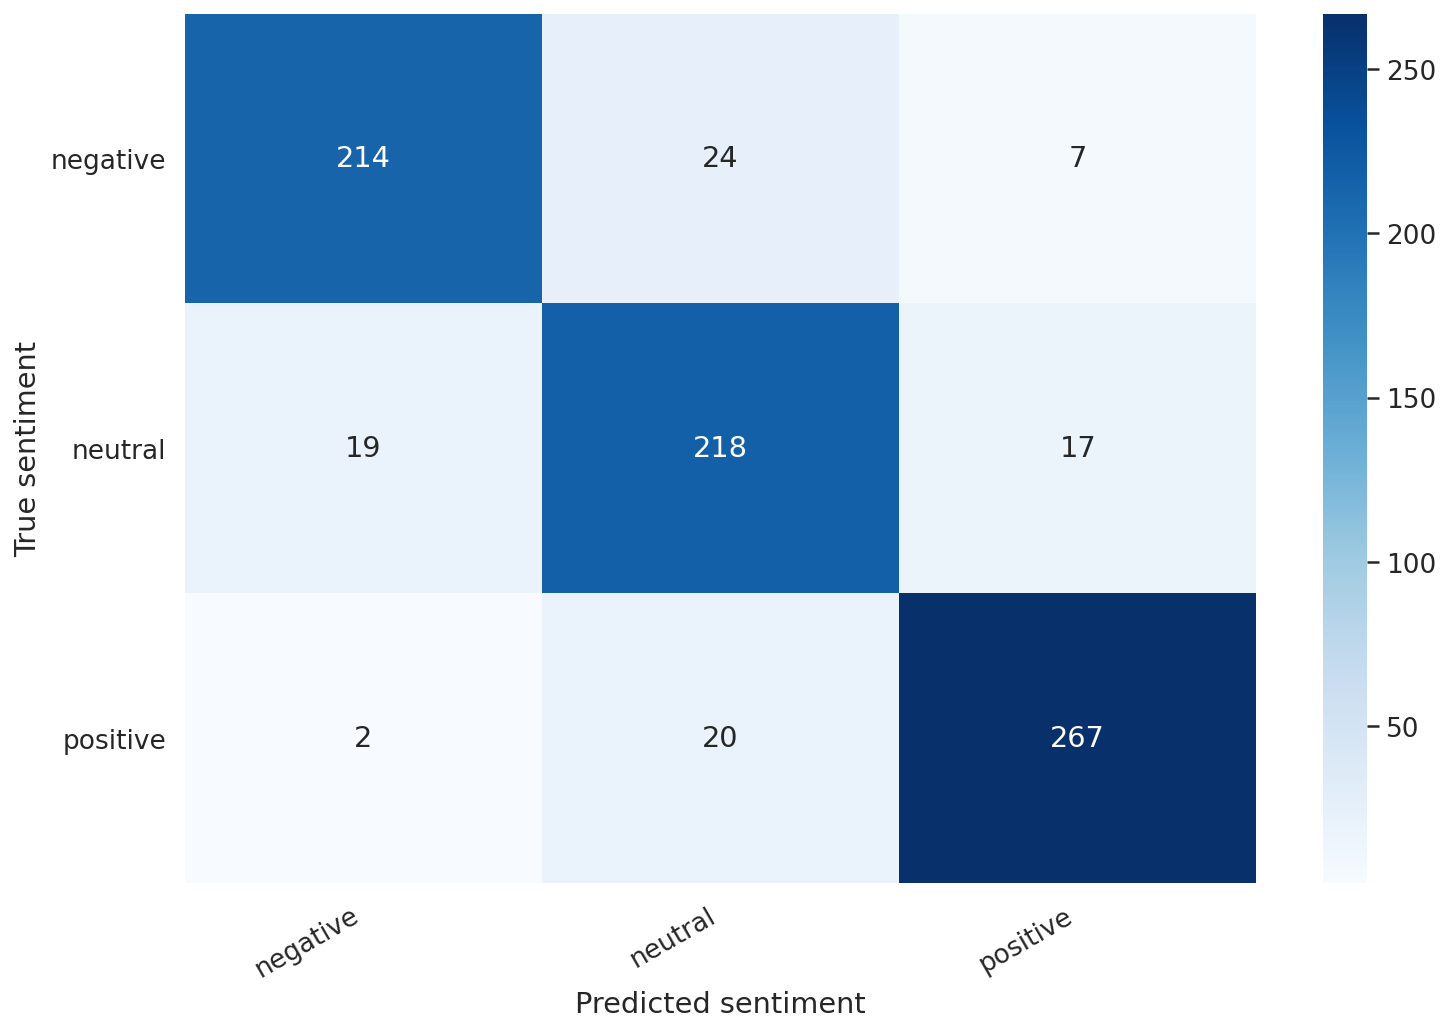

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica and I must say this is a great step up Id like
to see more social features such as sharing tasks only one person has
to perform said task for it to be checked off but only giving that
person the experience and gold Otherwise the price for subscription is
too steep thus resulting in a subperfect score I could easily justify
099month or eternal subscription for 15 If that price could be met as
well as fine tuning this would be easily worth 5 stars

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

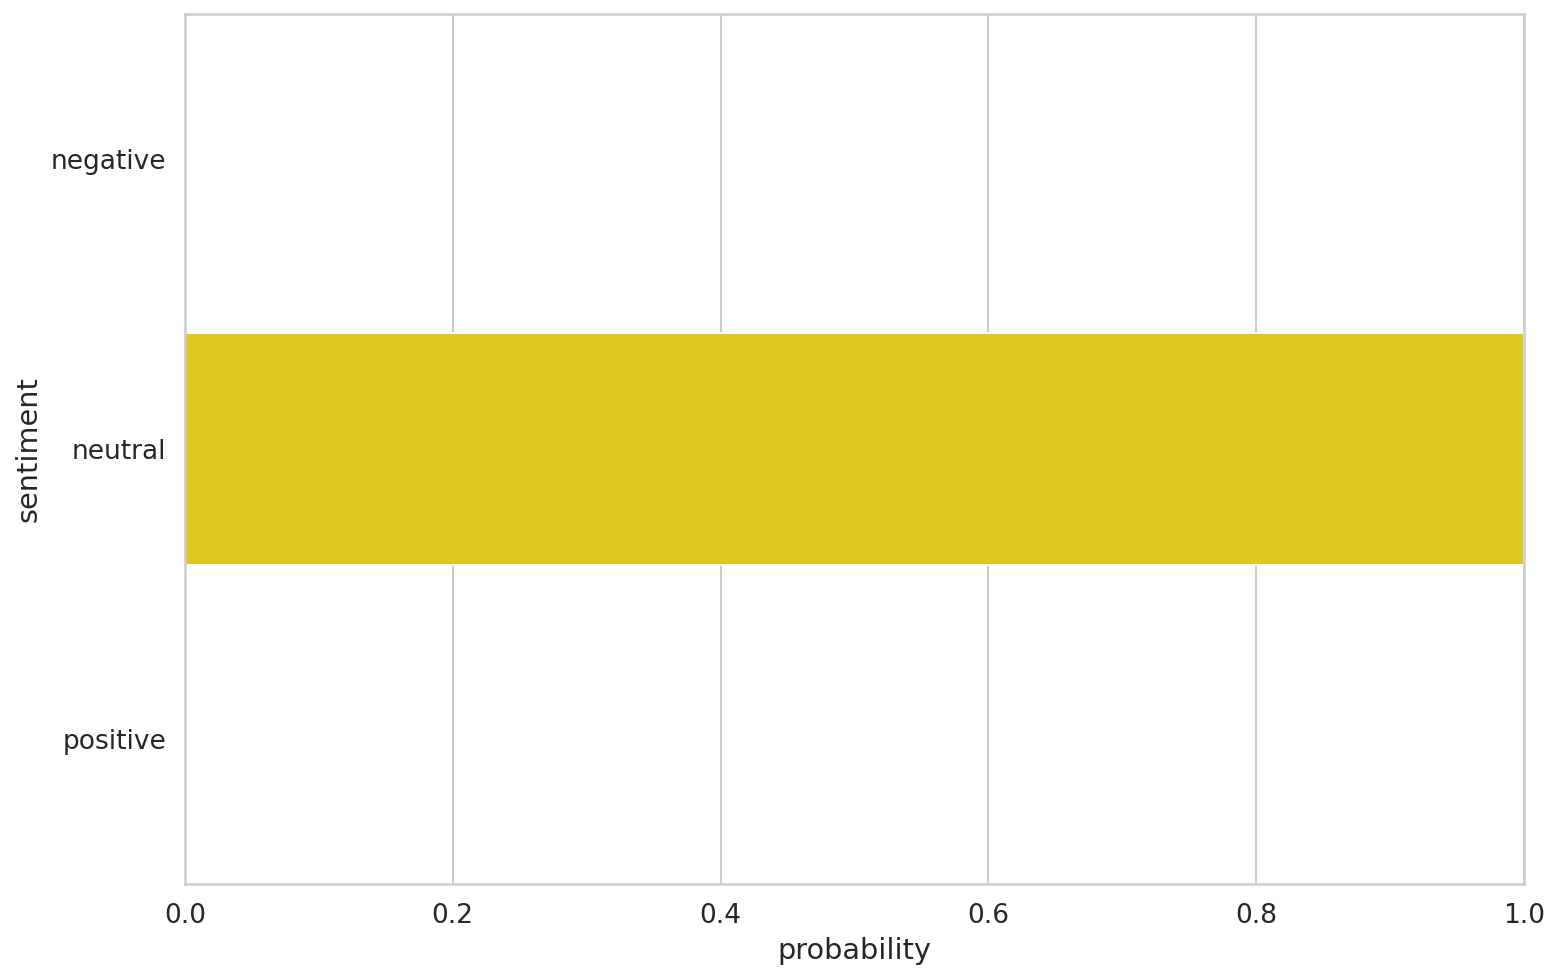

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Summary

Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)